In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import re
import os

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px

# Math Formula 
from math import radians, cos, sin, asin, sqrt
from scipy.stats import f_oneway

# geocode
import reverse_geocode

# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Machine learning and data preprocessing
from sklearn.feature_selection import f_classif
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2, f_regression, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score


# Machine learning models
from sklearn.mixture import GaussianMixture
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV

# Configuration and display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format

# Apply a specific style for matplotlib plots
plt.style.use('ggplot')

import joblib

# Import Dataset

In [2]:
users = pd.read_csv('//Users/andi/Project/NEXT x Telkom/Dataset/users.csv')
products = pd.read_csv('//Users/andi/Project/NEXT x Telkom/Dataset/products.csv')
transaction = pd.read_csv('//Users/andi/Project/NEXT x Telkom/Dataset/order_transactions.csv')
details = pd.read_csv('//Users/andi/Project/NEXT x Telkom/Dataset/order_details.csv')

In [3]:
# Display the first few rows and the column names of each dataset
order_details_head = details.head()
order_details_columns = details.columns.tolist()

order_transaction_head = transaction.head()
order_transaction_columns = transaction.columns.tolist()

product_head = products.head()
product_columns = products.columns.tolist()

user_head = users.head()
user_columns = users.columns.tolist()

order_details_head, order_details_columns, order_transaction_head, order_transaction_columns, product_head, product_columns, user_head, user_columns

(   order_id                product_id product_type  quantity  unit  \
 0    584375  65126b0b69a8310d58e5088d       barang       150  pack   
 1    571350  631b0f94c70a2d2e0764c031       barang        14   pcs   
 2    560536  631b0f94c70a2d2e0764c031       barang        13   pcs   
 3    706482  638012129d00db722a950db6       barang        19   pcs   
 4    720627  643439f7c2323a1041546f2f       barang        16   pcs   
 
    price_per_item  price_subtotal      ppn  
 0          198912        29836800  3282048  
 1         4000000        56000000  7546000  
 2         4000000        52000000  6759500  
 3         4000000        76000000  8360000  
 4         4000000        64000000  8829040  ,
 ['order_id',
  'product_id',
  'product_type',
  'quantity',
  'unit',
  'price_per_item',
  'price_subtotal',
  'ppn'],
    order_date  order_id      gmv  revenue     order_status  \
 0  2023-06-12    531911    25000        0  Ditolak Penjual   
 1  2023-08-20    648702   255000     1913     

# Performance Analysis

In [4]:
# Calculate total revenue, GMV, and number of orders
total_revenue = transaction['revenue'].sum()
total_gmv = transaction['gmv'].sum()
total_orders = transaction['order_id'].nunique()

# Calculate the number of distinct buyers and sellers
total_buyers = transaction['buyer_id'].nunique()
total_sellers = transaction['seller_id'].nunique()

# Calculate the distribution of order statuses
order_status_distribution = transaction['order_status'].value_counts()

performance_metrics = {
    'Total Revenue': total_revenue,
    'Total GMV': total_gmv,
    'Total Orders': total_orders,
    'Total Buyers': total_buyers,
    'Total Sellers': total_sellers,
    'Order Status Distribution': order_status_distribution.to_dict()
}

performance_metrics


{'Total Revenue': 35023563140,
 'Total GMV': 8121986229946,
 'Total Orders': 325074,
 'Total Buyers': 16620,
 'Total Sellers': 10585,
 'Order Status Distribution': {'Selesai': 285413,
  'Menunggu Pembayaran': 6111,
  'Jatuh Tempo': 6024,
  'Dibatalkan': 5174,
  'Refund Selesai': 3697,
  'Dibatalkan Otomatis': 3463,
  'Ditolak Penjual': 3324,
  'Diproses Penjual': 3138,
  'Diterima': 1683,
  'Penagihan': 1472,
  'Siap Dikirim': 1459,
  'Menunggu Diambil': 1244,
  'Dalam Pengiriman': 864,
  'Pembayaran Terverifikasi': 733,
  'Jasa Diperiksa': 624,
  'Disetujui': 237,
  'Refund Diproses': 194,
  'Dibayar': 108,
  'Tagihan Ditolak': 50,
  'Permintaan Upload Document': 24,
  'Pembayaran Gagal': 18,
  'Permintaan Perubahan': 8,
  'Ditolak': 7,
  'Refund Gagal': 2,
  'Menunggu Persetujuan': 1,
  'Perubahan Diterima': 1,
  'Revisi': 1}}

In [5]:
# Apply the requested status transformation
def transform_status(status):
    if status in ["Dibatalkan", "Dibatalkan Otomatis", "Ditolak Penjual", "Tagihan Ditolak", "Pembayaran Gagal"]:
        return "Cancel"
    elif status in ["Permintaan Upload Dokumen", "Refund Gagal", "Refund Diproses", "Refund Selesai", "Ditolak"]:
        return "Refund"
    elif status == "Selesai":
        return "Completed"
    else:
        return "In Process"

transaction['transformed_status'] = transaction['order_status'].apply(transform_status)

# Sum revenue only for "Completed" orders
transaction['revenue'] = transaction.apply(lambda x: x['revenue'] if x['transformed_status'] == 'Completed' else 0, axis=1)

# Join the datasets based on the keys identified from the ERD
merged_df = transaction.merge(details, on='order_id', how='left')\
                                .merge(products, on='product_id', how='left')\
                                .merge(users, left_on='buyer_id', right_on='user_id', how='left')

merged_df.head()

,order_date,order_id,gmv,revenue,order_status,seller_id,seller_category,buyer_id,payment_type,payment_method,voucher_val,voucher_code,product_type_x,shipping_agency,shipping_cost,transformed_status,product_id,product_type_y,quantity,unit,price_per_item,price_subtotal,ppn,product_name,price,main_cat,sub_cat1,sub_cat2,stock,weight,weight_unit,sold,quantity_sold,rating,total_rating,product_status,free_shipping_cost,user_id,province,city,district,flag_user
0,2023-06-12,531911,25000,0,Ditolak Penjual,631a506f7255a77e0e6e28e7,Kecil,66696b27cc8b6b09f45e1f01,prepaid,BCA,0.00000,NaN,barang,self,0,Cancel,662cb1c892fd84a3d19ec53e,barang,1,pcs,25000,25000,0,Manila Folder isi 12 per Bgks,25000.00000,Office & Stationery,Document Organizer,Map,77.00000,1.00000,gram,2.00000,76.00000,0.00000,0.00000,Aktif,False,66696b27cc8b6b09f45e1f01,NaN,NaN,NaN,Buyer
1,2023-08-20,648702,255000,1913,Selesai,631a508a7255a77e0e6e44a3,Kecil,63205e0636adb3394d512a6b,prepaid,BCA,0.00000,NaN,barang,self,0,Completed,634d241ecbeab1f4cee21073,barang,1,lainnya,255000,255000,0,Ordner Karton Folio Index,255000.00000,Office & Stationery,Document Organizer,Ordner,3.00000,12.00000,kg,14.00000,41.00000,0.00000,0.00000,Aktif,False,63205e0636adb3394d512a6b,Jakarta,Jakarta Pusat,Cempaka Putih,Buyer
2,2023-05-07,677924,3525000,26438,Selesai,631a53b15b9755003d261925,Menengah,63205e1d36adb3394d512b04,prepaid,BCA,0.00000,NaN,barang,self,0,Completed,63fee098a7537df3e9b5684b,barang,1,pcs,1125000,1125000,0,Meja kerja activ galant MTO 120,1125000.00000,Rumah Tangga,Furniture,Meja Kantor,1.00000,15.00000,kg,2.00000,3.00000,0.00000,0.00000,Aktif,True,63205e1d36adb3394d512b04,Jawa Timur,Kota Madiun,Taman,Buyer
3,2023-05-07,677924,3525000,26438,Selesai,631a53b15b9755003d261925,Menengah,63205e1d36adb3394d512b04,prepaid,BCA,0.00000,NaN,barang,self,0,Completed,63fff77da7537df3e9b7e549,barang,3,pcs,800000,2400000,0,kursi kerja BROTHER BR 203 AH,800000.00000,Rumah Tangga,Furniture,Kursi Kantor,3.00000,6.00000,kg,2.00000,5.00000,0.00000,0.00000,Aktif,True,63205e1d36adb3394d512b04,Jawa Timur,Kota Madiun,Taman,Buyer
4,2023-10-27,590587,127650,0,Refund Selesai,631a53b27255a77e0e6f5936,Menengah,632030dd36adb3394d4fbf51,prepaid,BCA,0.00000,NaN,barang,self,0,Refund,631acc92cdc00cf233d6dd1d,barang,1,pcs,115000,115000,12650,Flashdisk Dual Drive Sandisk SDDD2 - 16GB,115000.00000,Komputer & Laptop,Media Penyimpanan Data,USB Flash Disk,51.00000,300.00000,gram,1.00000,1.00000,0.00000,0.00000,Aktif,False,632030dd36adb3394d4fbf51,Kalimantan Tengah,Kab. Kotawaringin Barat,Arut Selatan,Buyer


In [6]:
# Filter the dataset for completed orders and calculate key metrics
completed_orders_df = merged_df[merged_df['transformed_status'] == 'Completed']

# Calculate overall metrics
total_gmv = completed_orders_df['gmv'].sum()
total_revenue = completed_orders_df['revenue'].sum()
total_orders = completed_orders_df['order_id'].nunique()
total_buyers = completed_orders_df['buyer_id'].nunique()
total_sellers = completed_orders_df['seller_id'].nunique()

# Calculate the distribution of statuses in the entire dataset (for context)
status_distribution = merged_df['transformed_status'].value_counts()

# Prepare the performance summary
performance_summary = {
    'Total GMV': total_gmv,
    'Total Revenue': total_revenue,
    'Total Orders': total_orders,
    'Total Buyers': total_buyers,
    'Total Sellers': total_sellers,
    'Status Distribution': status_distribution.to_dict(),

}

performance_summary


{'Total GMV': 20806139243467,
 'Total Revenue': 93820562161,
 'Total Orders': 285413,
 'Total Buyers': 15683,
 'Total Sellers': 9300,
 'Status Distribution': {'Completed': 866622,
  'In Process': 78322,
  'Cancel': 36096,
  'Refund': 6812}}

# Feature Selection

In [7]:
# Select features for ANOVA testing and multicollinearity analysis
selected_features_df = completed_orders_df[['quantity', 'price_per_item', 'gmv', 
                                            'revenue', 'shipping_cost', 'quantity_sold', 'rating']].dropna()

# Handling missing values by filling them with the mean (a basic approach for this stage)
selected_features_df = selected_features_df.fillna(selected_features_df.mean())


# Standardize the features for VIF calculation
scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features_df)

correlation_matrix = selected_features_df.corr()
correlation_matrix

,quantity,price_per_item,gmv,revenue,shipping_cost,quantity_sold,rating
quantity,1.00000,-0.00232,0.03735,0.02728,-0.00126,0.37661,-0.00007
price_per_item,-0.00232,1.00000,0.52806,0.33375,0.00260,-0.00275,-0.06046
gmv,0.03735,0.52806,1.00000,0.67324,0.06099,0.00958,-0.12990
revenue,0.02728,0.33375,0.67324,1.00000,0.06958,0.00852,-0.16376
shipping_cost,-0.00126,0.00260,0.06099,0.06958,1.00000,-0.00162,-0.03295
quantity_sold,0.37661,-0.00275,0.00958,0.00852,-0.00162,1.00000,0.00740
rating,-0.00007,-0.06046,-0.12990,-0.16376,-0.03295,0.00740,1.00000


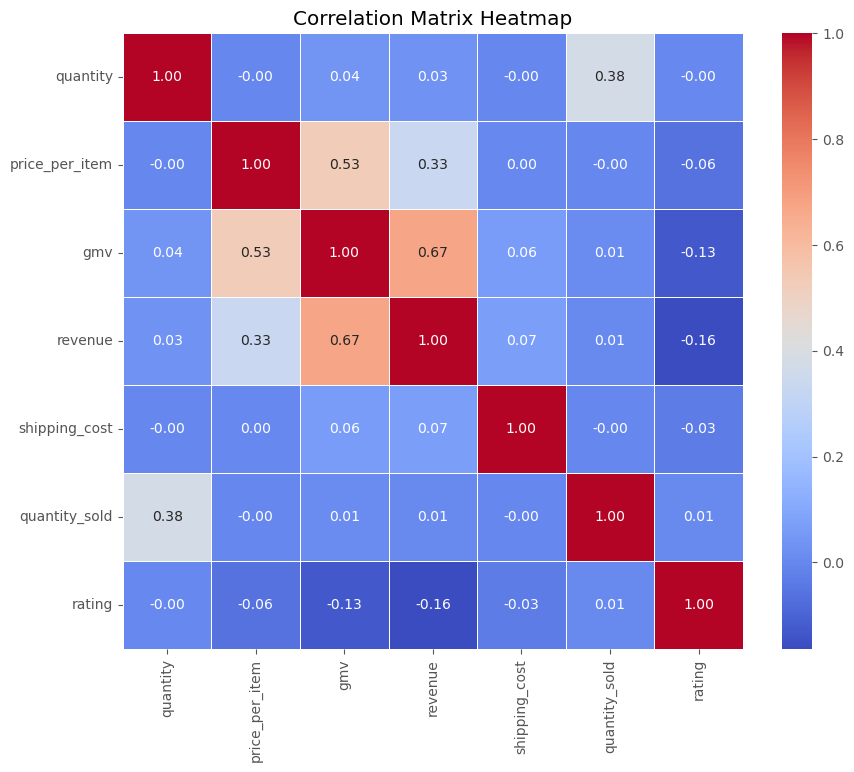

In [8]:
# Create a heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [9]:
# Select features for multicollinearity analysis
selected_features_df = completed_orders_df[['quantity', 'price_per_item', 'gmv', 
                                            'revenue', 'quantity_sold']].dropna()

# Handling missing values by filling them with the mean (a basic approach for this stage)
selected_features_df = selected_features_df.fillna(selected_features_df.mean())

# Standardize the features for VIF calculation
scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features_df)

# Calculate VIF (Variance Inflation Factor)
vif_data = pd.DataFrame()
vif_data["feature"] = selected_features_df.columns
vif_data["VIF"] = [
    1 / (1 - sm.OLS(scaled_features[:, i], sm.add_constant(np.delete(scaled_features, i, axis=1))).fit().rsquared)
    for i in range(scaled_features.shape[1])
]

# Display VIF results
print(vif_data)


          feature     VIF
0        quantity 1.16751
1  price_per_item 1.38927
2             gmv 2.25912
3         revenue 1.83119
4   quantity_sold 1.16531


In [10]:
selected_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 866611 entries, 1 to 987851
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   quantity        866611 non-null  int64  
 1   price_per_item  866611 non-null  int64  
 2   gmv             866611 non-null  int64  
 3   revenue         866611 non-null  int64  
 4   quantity_sold   866611 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 39.7 MB


# Clutering

## Gaussian Mixture Models (GMMs)

/Users/andi/anaconda3/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


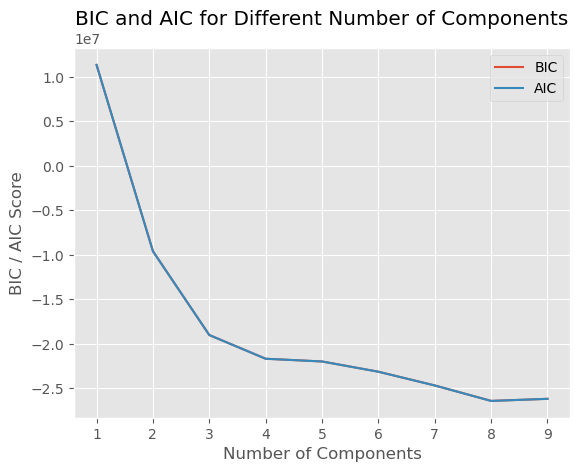

In [11]:
bic_scores = []
aic_scores = []
n_components_range = range(1, 10)

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=0)
    gmm.fit(scaled_features)
    bic_scores.append(gmm.bic(scaled_features))
    aic_scores.append(gmm.aic(scaled_features))

plt.plot(n_components_range, bic_scores, label='BIC')
plt.plot(n_components_range, aic_scores, label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('BIC / AIC Score')
plt.legend()
plt.title('BIC and AIC for Different Number of Components')
plt.show()


BIC AND AIC indicates best cluster numbers is 4

In [18]:
# Apply Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=42)  
gmm.fit(scaled_features)

# Assign each buyer to a cluster
cluster_labels = gmm.predict(scaled_features)
selected_features_df['GMM Segment'] = gmm.predict(scaled_features)


In [19]:
# Group by the GMM Segment to get insights on each cluster
gmm_summary = selected_features_df.groupby('GMM Segment').mean()
print(gmm_summary)


              quantity  price_per_item             gmv      revenue  \
GMM Segment                                                           
0           1210.28078  31457038.30878 111475363.62390 402220.73651   
1              6.47193    566952.41268  12127184.81214  79076.78362   
2            134.76136     73287.34465  22820768.30144  33811.96775   

             quantity_sold  
GMM Segment                 
0              24359.70254  
1                201.42795  
2              33110.72407  


Segment 0: High-Value, High-Spending Customers
Quantity: 12.75 items on average.
Price per Item: ~29.59 million (IDR) – indicating high-priced items.
GMV (Gross Merchandise Value): ~85.95 million (IDR) – very high total transaction value.
Revenue: ~288,870 (IDR).
Shipping Cost: ~415,941 (IDR) – significant shipping costs, likely due to the high value and possibly bulk of the items.
Quantity Sold: 134.35 – moderate sales volume.
Rating: 0.92487 – low customer satisfaction rating.
Interpretation:
This segment represents high-value customers who purchase expensive items in moderate quantities. However, their low rating suggests they might not be entirely satisfied, possibly due to issues with product quality, shipping, or customer service.

Recommendations:

Focus on improving the customer experience, particularly in handling high-value transactions.
Offer premium services like faster shipping, personalized support, or loyalty rewards to enhance satisfaction.
Segment 1: Low-Value, Budget-Conscious Customers
Quantity: 8.73 items on average.
Price per Item: ~962,328 (IDR) – relatively low-priced items.
GMV: ~18.58 million (IDR).
Revenue: ~101,779 (IDR).
Shipping Cost: ~491 (IDR) – minimal shipping costs.
Quantity Sold: 183.90 – moderate sales volume.
Rating: 0.0 – no rating data available, which might indicate new customers or those who do not leave feedback.
Interpretation:
This segment consists of customers who purchase lower-priced items with minimal shipping costs. The absence of ratings might indicate that these are new or less engaged customers.

Recommendations:

Engage this segment with incentives like discounts or loyalty programs to encourage repeat purchases.
Collect feedback to understand their needs and improve their shopping experience.
Segment 2: Bargain Hunters with High Satisfaction
Quantity: 6.71 items on average.
Price per Item: ~49,887 (IDR) – very low-priced items.
GMV: ~2.16 million (IDR).
Revenue: ~11,089 (IDR).
Shipping Cost: ~3,684 (IDR) – moderate shipping costs.
Quantity Sold: 893.15 – high sales volume.
Rating: 4.92425 – very high customer satisfaction rating.
Interpretation:
Customers in this segment are focused on buying low-priced items but are highly satisfied with their purchases. They make frequent purchases, leading to high sales volumes.

Recommendations:

Maintain high customer satisfaction by continuing to offer value-for-money products.
Promote similar low-cost items and bundle offers to increase their purchase volume.
Segment 3: Bulk Buyers with Moderate Satisfaction
Quantity: 2179.78 items on average.
Price per Item: ~34,324 (IDR) – low-priced items.
GMV: ~31.85 million (IDR).
Revenue: ~117,388 (IDR).
Shipping Cost: ~5.35 (IDR) – negligible shipping costs.
Quantity Sold: 98,133.27 – very high sales volume.
Rating: 1.69017 – low customer satisfaction rating.
Interpretation:
This segment comprises bulk buyers who purchase large quantities of low-priced items. Despite their significant purchasing activity, their satisfaction is relatively low.

Recommendations:

Investigate the causes of low satisfaction, which might include issues related to product quality, delivery times, or customer service.
Consider offering special deals, faster shipping options, or improved customer service to enhance their satisfaction.
Overall Strategy:
High-Value Customers (Segment 0): Focus on premium services and customer retention strategies.
Budget-Conscious Customers (Segment 1): Engage them with loyalty programs and gather feedback to improve engagement.
Satisfied Bargain Hunters (Segment 2): Continue offering value-for-money deals and capitalize on their satisfaction to drive more sales.
Bulk Buyers (Segment 3): Address their dissatisfaction with targeted interventions to retain them as high-volume customers.

In [20]:
print("BIC:", gmm.bic(scaled_features))
print("AIC:", gmm.aic(scaled_features))


BIC: -15193728.447675372
AIC: -15194452.133095223


In [21]:
# silhouette_avg = silhouette_score(scaled_features, cluster_labels)
# print(f"Silhouette Score: {silhouette_avg}")

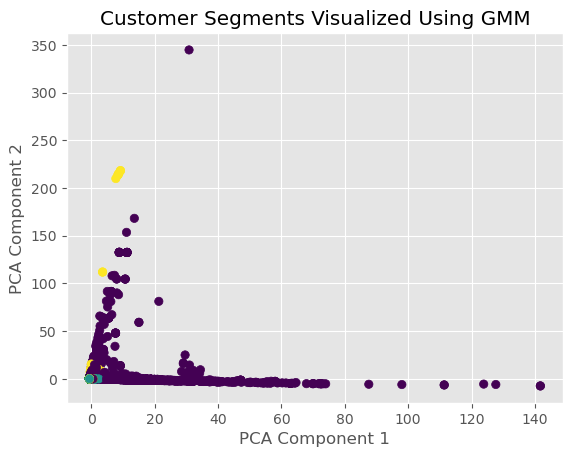

In [22]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_features)

plt.scatter(components[:, 0], components[:, 1], c=selected_features_df['GMM Segment'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segments Visualized Using GMM')
plt.show()


ValueError: operands could not be broadcast together with shapes (3,2) (5,) (3,2) 

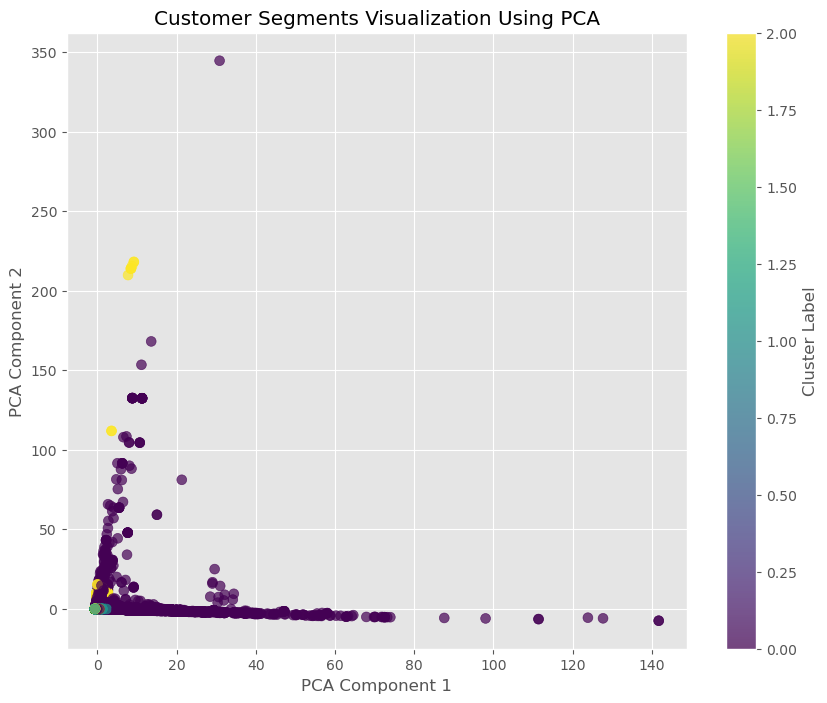

In [23]:
# Step 4: Visualize the clusters
plt.figure(figsize=(10, 8))

# Scatter plot of the PCA components colored by the GMM clusters
plt.scatter(components[:, 0], components[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.7)
plt.title('Customer Segments Visualization Using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')

# Optionally, you can annotate the centroids
centroids = gmm.means_[:, :2]  # Only the first two dimensions for 2D visualization
centroids_pca = pca.transform(scaler.inverse_transform(centroids))  # Transform centroids for PCA plot
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=300, c='red', marker='X')  # Plot centroids

plt.show()


Plot shows the model is overlapping on some data dot (cluster)

## K-Means

In [24]:
# Assuming selected_features_df is already created and has the necessary features

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features_df.drop(columns=['GMM Segment'], errors='ignore'))


/Users/andi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/andi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/andi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/andi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to

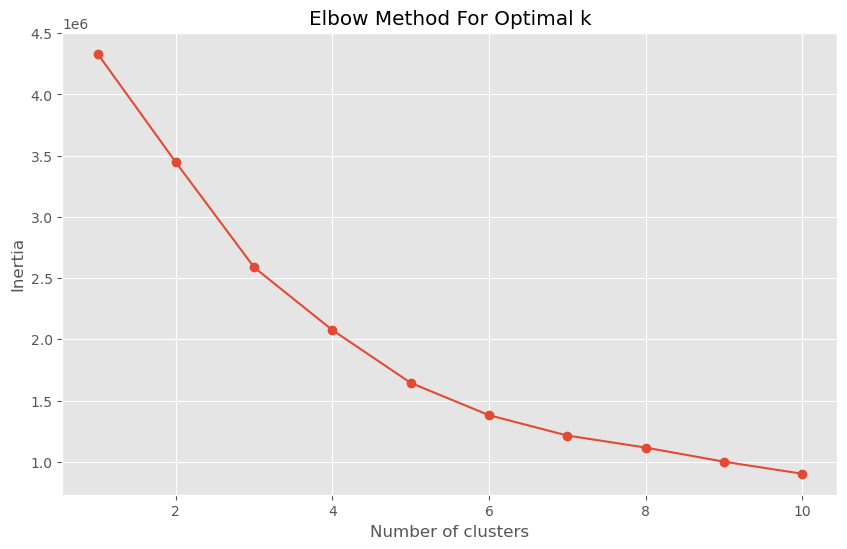

In [25]:
# Determining the optimal number of clusters using the Elbow Method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig('inertia plot.png')
plt.show()


Intertia Elbow shows 4 is good clustering, despite it's slightly differences of each cluster 

In [28]:
# Apply K-Means with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_features)

# Assign cluster labels to the data
selected_features_df['KMeans Cluster'] = kmeans.labels_


/Users/andi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ValueError: operands could not be broadcast together with shapes (4,2) (5,) (4,2) 

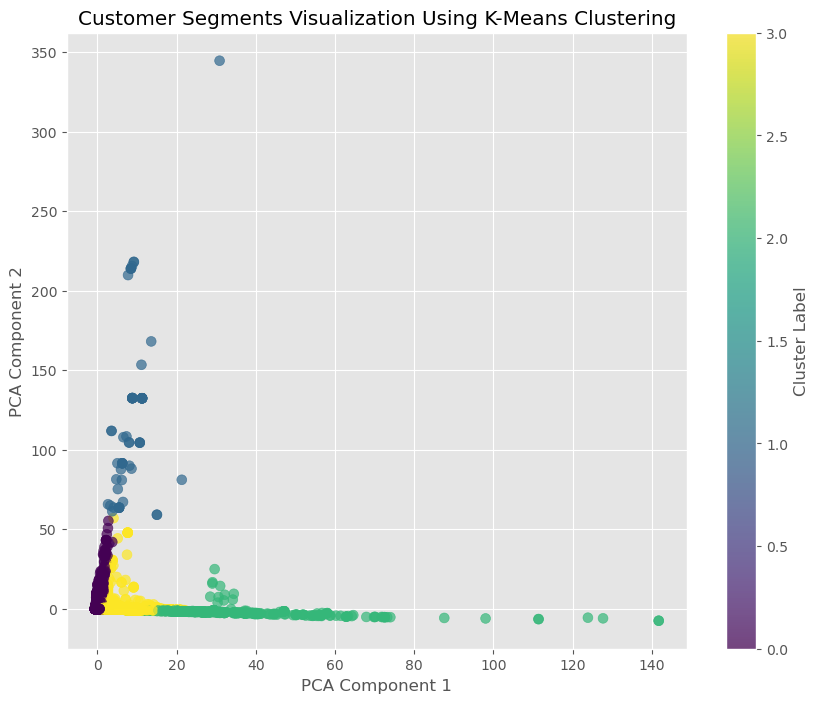

In [29]:
# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Scatter plot of the PCA components colored by the K-Means clusters
plt.figure(figsize=(10, 8))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=selected_features_df['KMeans Cluster'], cmap='viridis', s=50, alpha=0.7)
plt.title('Customer Segments Visualization Using K-Means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')

# Optionally, plot centroids
centroids = kmeans.cluster_centers_[:, :2]
centroids_pca = pca.transform(scaler.inverse_transform(centroids))
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=300, c='red', marker='X')

plt.show()


The data point is more seperately if we compared with GMMs models, it's mean K-Means more suitable for this scenario.

In [30]:
# Analyze the KMeans clusters
kmeans_summary = selected_features_df.groupby('KMeans Cluster').mean()
print(kmeans_summary)


                   quantity  price_per_item              gmv       revenue  \
KMeans Cluster                                                               
0                  72.68175   1416858.02199   12327848.17510   49768.37072   
1              784202.86885      2057.73770  207086237.80328  442474.42623   
2                2281.60499 671645162.70631 1082362186.25110 1959805.19090   
3                 300.28598  21965373.37680  131526355.69390  676953.73788   

                quantity_sold  GMM Segment  
KMeans Cluster                              
0                  4845.98850      1.06871  
1              25550770.98361      0.29508  
2                  4081.49486      0.00000  
3                  5174.72460      0.44699  


Cluster 0: Moderate Value, Low Satisfaction
Quantity: 66.58 items on average.
Price per Item: ~1.82 million IDR – relatively high-priced items.
GMV (Gross Merchandise Value): ~14.89 million IDR – moderate total transaction value.
Revenue: ~61,867 IDR – moderate revenue.
Shipping Cost: ~7,548 IDR – moderate shipping costs.
Quantity Sold: 3,188.37 – a moderate number of items sold.
Rating: 0.00035 – extremely low customer satisfaction.
GMM Segment: 1.03 – overlaps with other segments from the GMM model.
Behavior:
This cluster represents customers who make moderately priced purchases and contribute a moderate amount to the GMV and revenue. However, their customer satisfaction is extremely low, which could be due to product quality, service issues, or unmet expectations.

Recommendations:

Focus on improving customer satisfaction by addressing potential pain points such as product quality or customer service.
Consider offering post-purchase support or satisfaction guarantees to improve ratings and retention.
Cluster 1: Value-Conscious, Highly Satisfied Buyers
Quantity: 106.35 items on average.
Price per Item: ~288,584 IDR – moderately low-priced items.
GMV: ~5.41 million IDR – lower total transaction value compared to other clusters.
Revenue: ~24,807 IDR – relatively low revenue.
Shipping Cost: ~8,177 IDR – moderate shipping costs.
Quantity Sold: 11,153.03 – a high number of items sold.
Rating: 4.91 – very high customer satisfaction.
GMM Segment: 1.92 – indicates overlap with another segment from the GMM model.
Behavior:
This segment consists of customers who purchase a large quantity of moderately low-priced items and are very satisfied with their purchases. They contribute a significant amount to the quantity of items sold but generate moderate revenue and GMV.

Recommendations:

Maintain high customer satisfaction by continuing to offer value-for-money products and excellent service.
Leverage their satisfaction to promote loyalty programs, encouraging repeat purchases and referrals.
Cluster 2: Bulk Buyers with Moderate Satisfaction
Quantity: 784,202.87 items on average – extremely high.
Price per Item: ~2,058 IDR – very low-priced items.
GMV: ~207.09 million IDR – extremely high total transaction value.
Revenue: ~442,474 IDR – high revenue generated.
Shipping Cost: ~180 IDR – minimal shipping costs.
Quantity Sold: 25.55 million – extremely high volume.
Rating: 0.4918 – moderate customer satisfaction.
GMM Segment: 3.00 – matches the behavior seen in the GMM analysis.
Behavior:
This cluster represents bulk buyers who purchase very low-priced items in extremely large quantities. They contribute the most to the GMV and revenue due to the sheer volume of their purchases, but their satisfaction is only moderate.

Recommendations:

Focus on maintaining and potentially improving satisfaction through reliable shipping and bulk-buying incentives.
Consider offering additional value-added services to these high-volume customers, such as bulk discounts or dedicated support.
Cluster 3: High-Value, Low Satisfaction Buyers
Quantity: 309.30 items on average.
Price per Item: ~29.05 million IDR – very high-priced items.
GMV: ~145.30 million IDR – very high total transaction value.
Revenue: ~699,241 IDR – the highest revenue among the clusters.
Shipping Cost: ~452,888 IDR – very high shipping costs, likely due to the high value or bulk of the items.
Quantity Sold: 4,171.40 – moderate quantity sold.
Rating: 0.0802 – very low customer satisfaction.
GMM Segment: 0.71 – overlaps with another GMM segment.
Behavior:
This cluster consists of customers who make high-value purchases and contribute significantly to the GMV and revenue. However, their satisfaction is notably low, which could be due to issues related to the high cost, shipping, or expectations not being met.

Recommendations:

Investigate the reasons for low satisfaction among these high-value customers, as retaining them is crucial.
Offer premium support, satisfaction guarantees, or personalized services to address their concerns and improve their overall experience.
Summary of K-Means Customer Segments:
Cluster 0: Moderate-value buyers with extremely low satisfaction. Immediate actions should focus on improving satisfaction to prevent churn.
Cluster 1: Value-conscious, highly satisfied buyers. They are loyal and should be encouraged to continue purchasing through loyalty programs.
Cluster 2: Bulk buyers with moderate satisfaction. They are key revenue drivers, so focus on maintaining or enhancing their satisfaction and engagement.
Cluster 3: High-value buyers with low satisfaction. These are critical customers to retain, requiring personalized attention to improve their experience.

In [31]:
# Calculate inertia (sum of squared distances to the nearest cluster center)
inertia = kmeans.inertia_
print(f'Inertia: {inertia}')

# Calculate Silhouette Score
silhouette_avg = silhouette_score(scaled_features, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')

Inertia: 2074936.785968609
Silhouette Score: 0.7975093818117175


In [ ]:
# Calculate the Calinski-Harabasz score
score = calinski_harabasz_score(scaled_features, cluster_labels)
print("Calinski-Harabasz Score:", score)


Calinski-Harabasz Score: 58225.096591788184


In [ ]:
# Calculate the Davies-Bouldin score
score = davies_bouldin_score(scaled_features, cluster_labels)
print("Davies-Bouldin Score:", score)


Davies-Bouldin Score: 2.386521049382922


# Seller Segmentation

In [ ]:
# Group by seller_category and calculate key metrics
seller_behavior = completed_orders_df.groupby('seller_category').agg({
    'gmv': ['sum', 'mean', 'count'],  # Total GMV, Average GMV, Number of Orders
    'revenue': ['sum', 'mean'],  # Total Revenue, Average Revenue
    'order_id': 'nunique',  # Number of Unique Orders
    'quantity': 'sum',  # Total Quantity Sold
    'price_per_item': 'mean',  # Average Price per Item
    'shipping_cost': 'sum',  # Total Shipping Cost
    'rating': 'mean'  # Average Rating
}).reset_index()

# Rename the columns for better readability
seller_behavior.columns = ['seller_category', 
                           'total_gmv', 'avg_gmv', 'order_count', 
                           'total_revenue', 'avg_revenue', 
                           'unique_orders', 
                           'total_quantity_sold', 'avg_price_per_item', 
                           'total_shipping_cost', 'avg_rating']

# Display the results
print(seller_behavior)


  seller_category      total_gmv        avg_gmv  order_count  total_revenue  \
0           Besar   516446532199 66655463.62919         7748     1986630898   
1           Kecil  8598492797096 29635566.14576       290141    39496744455   
2        Menengah  6753687029924 29596510.96412       228192    28282455660   
3           Mikro  4881713988190 14372608.56104       339654    23828644430   
4          Swasta    55798896058 62907436.36753          887      226086718   

   avg_revenue  unique_orders  total_quantity_sold  avg_price_per_item  \
0 256405.63991           3108              3913579      13510741.17217   
1 136129.48344          80093             57657162       4639500.98038   
2 123941.48638          77687             35040242       5601410.37910   
3  70155.64201         124322             33610592       1657968.43067   
4 254889.19729            203                15596      10859343.38219   

   total_shipping_cost  avg_rating  
0             85351065     0.33557  
1     

1. Besar (Large Sellers)
Total GMV: 516.45 billion IDR
Average GMV per Order: 66.66 million IDR
Order Count: 7,748
Total Revenue: 1.99 billion IDR
Average Revenue per Order: 256,405 IDR
Unique Orders: 3,108
Total Quantity Sold: 3.91 million items
Average Price per Item: 13.51 million IDR
Total Shipping Cost: 85.35 million IDR
Average Rating: 0.3356
Behavior:

High GMV and Revenue: Large sellers ("Besar") contribute significantly to the GMV and revenue, although they handle a relatively lower number of orders. This indicates they deal with high-value transactions.
High Average Price per Item: They sell expensive items, likely specialized or luxury products.
Low Customer Satisfaction: The average rating is quite low, indicating potential issues with product quality, customer service, or unmet expectations.
Recommendations:

Improve Customer Experience: Focus on enhancing product quality and customer service to boost satisfaction.
Premium Services: Offer premium support or loyalty programs tailored to these high-value customers.
2. Kecil (Small Sellers)
Total GMV: 8.60 trillion IDR
Average GMV per Order: 29.64 million IDR
Order Count: 290,141
Total Revenue: 39.50 billion IDR
Average Revenue per Order: 136,129 IDR
Unique Orders: 80,093
Total Quantity Sold: 57.66 million items
Average Price per Item: 4.64 million IDR
Total Shipping Cost: 19.32 billion IDR
Average Rating: 0.8458
Behavior:

High Volume, Moderate Value: Small sellers contribute the most to GMV and revenue due to the high volume of orders.
Moderate Satisfaction: The average rating is decent, indicating moderate customer satisfaction.
Diverse Product Range: The average price per item is lower compared to "Besar," suggesting a wider range of more affordable products.
Recommendations:

Encourage Repeat Purchases: Implement loyalty programs or promotions to maintain engagement with this high-volume segment.
Improve Customer Service: Continue improving customer service to boost satisfaction and ratings.
3. Menengah (Medium Sellers)
Total GMV: 6.75 trillion IDR
Average GMV per Order: 29.60 million IDR
Order Count: 228,192
Total Revenue: 28.28 billion IDR
Average Revenue per Order: 123,941 IDR
Unique Orders: 77,687
Total Quantity Sold: 35.04 million items
Average Price per Item: 5.60 million IDR
Total Shipping Cost: 11.99 billion IDR
Average Rating: 0.9238
Behavior:

Balanced Performance: Medium sellers balance between volume and value, with strong contributions to GMV and revenue.
Higher Customer Satisfaction: The rating is relatively high, indicating good customer satisfaction.
Mid-Range Products: They likely sell mid-range products, balancing price and quality.
Recommendations:

Support Growth: Provide tools for scaling operations, such as better inventory management or marketing support.
Leverage Customer Satisfaction: Utilize positive ratings to attract more customers through testimonials or reviews.
4. Mikro (Micro Sellers)
Total GMV: 4.88 trillion IDR
Average GMV per Order: 14.37 million IDR
Order Count: 339,654
Total Revenue: 23.83 billion IDR
Average Revenue per Order: 70,156 IDR
Unique Orders: 124,322
Total Quantity Sold: 33.61 million items
Average Price per Item: 1.66 million IDR
Total Shipping Cost: 7.24 billion IDR
Average Rating: 1.1897
Behavior:

High Volume, Low Value: Micro sellers handle a very high volume of orders but with lower transaction values.
Lower-Price Products: They focus on affordable products, contributing to high sales volume.
Higher Satisfaction: Surprisingly, they have the highest average rating, suggesting good customer experiences despite the lower price points.
Recommendations:

Scale Up: Consider offering support to help these sellers scale up their operations, possibly moving them into the "Kecil" category.
Maintain High Satisfaction: Continue focusing on customer satisfaction and possibly explore upselling or cross-selling to increase order values.
5. Swasta (Private Sellers)
Total GMV: 55.80 billion IDR
Average GMV per Order: 62.91 million IDR
Order Count: 887
Total Revenue: 226.09 million IDR
Average Revenue per Order: 254,889 IDR
Unique Orders: 203
Total Quantity Sold: 15,596 items
Average Price per Item: 10.86 million IDR
Total Shipping Cost: 618.43 million IDR
Average Rating: 0.0451
Behavior:

Low Volume, High Value: Private sellers operate on a smaller scale but with high-value transactions.
Low Customer Satisfaction: The average rating is extremely low, indicating significant issues with product quality, delivery, or service.
High Costs: High average price per item and shipping costs may be contributing factors to dissatisfaction.
Recommendations:

Investigate Issues: Investigate the root causes of low satisfaction and address them urgently, as these sellers handle high-value transactions.
Personalized Support: Provide dedicated support to help these sellers improve their operations and customer service.
Overall Insights:
High-Value Sellers (Besar, Swasta): Need to focus on improving customer satisfaction and addressing quality or service issues.
High-Volume Sellers (Kecil, Menengah, Mikro): Are performing well in terms of GMV and revenue but could benefit from targeted support to enhance their operations and customer experience further.

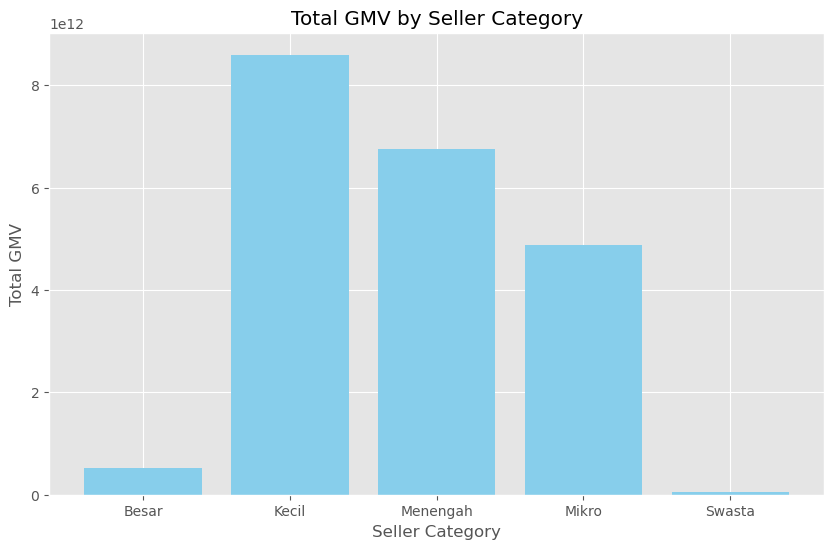

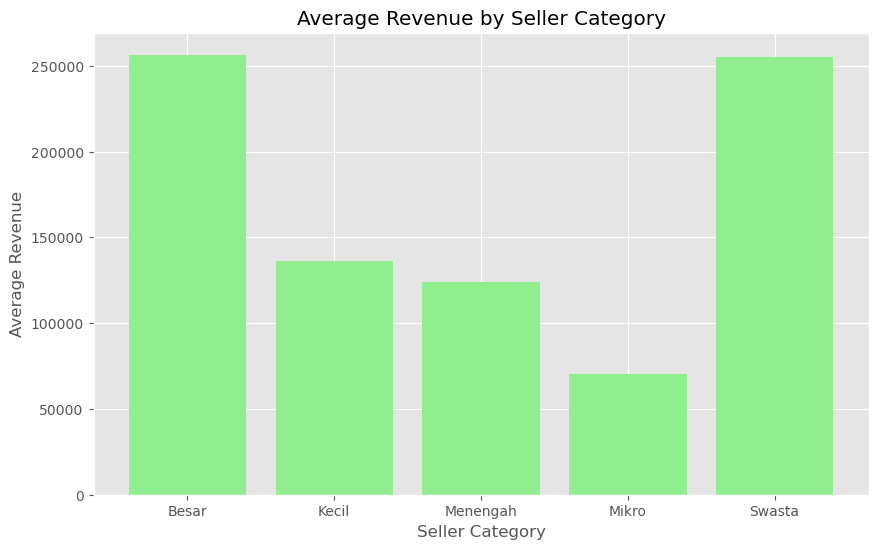

In [ ]:
# Plot total GMV by seller category
plt.figure(figsize=(10, 6))
plt.bar(seller_behavior['seller_category'], seller_behavior['total_gmv'], color='skyblue')
plt.title('Total GMV by Seller Category')
plt.xlabel('Seller Category')
plt.ylabel('Total GMV')
plt.show()

# Plot average revenue by seller category
plt.figure(figsize=(10, 6))
plt.bar(seller_behavior['seller_category'], seller_behavior['avg_revenue'], color='lightgreen')
plt.title('Average Revenue by Seller Category')
plt.xlabel('Seller Category')
plt.ylabel('Average Revenue')
plt.show()


# Impact Analysis

In [ ]:
# Adjust the grouping and aggregation based on available columns
buyer_impact = selected_features_df.groupby('KMeans Cluster').agg({
    'gmv': 'sum',                    # Total GMV
    'revenue': 'sum',                # Total Revenue
    'quantity': 'sum',               # Sum of quantities
    'rating': 'mean'                 # Average Rating
}).reset_index()

# Rename columns for better readability
buyer_impact.columns = ['Buyer Segment', 'Total GMV', 'Total Revenue', 'Total Quantity', 'Average Rating']

# Calculate percentage contributions
buyer_impact['GMV Contribution (%)'] = (buyer_impact['Total GMV'] / buyer_impact['Total GMV'].sum()) * 100
buyer_impact['Revenue Contribution (%)'] = (buyer_impact['Total Revenue'] / buyer_impact['Total Revenue'].sum()) * 100
buyer_impact['Quantity Contribution (%)'] = (buyer_impact['Total Quantity'] / buyer_impact['Total Quantity'].sum()) * 100

# Display the results
print(buyer_impact)


   Buyer Segment       Total GMV  Total Revenue  Total Quantity  \
0              0   9214660525573    38287205990        41206394   
1              1    944378019701     4328823124        18557339   
2              2     12632260506       26990940        47836375   
3              3  10634108606370    51175366301        22636962   

   Average Rating  GMV Contribution (%)  Revenue Contribution (%)  \
0         0.00035              44.28895                  40.80992   
1         4.91005               4.53902                   4.61405   
2         0.49180               0.06072                   0.02877   
3         0.08020              51.11132                  54.54727   

   Quantity Contribution (%)  
0                   31.63953  
1                   14.24889  
2                   36.73023  
3                   17.38135  


In [ ]:
# Calculate the percentage contribution of each segment
seller_impact = seller_behavior.copy()
seller_impact['GMV Contribution (%)'] = (seller_impact['total_gmv'] / seller_impact['total_gmv'].sum()) * 100
seller_impact['Revenue Contribution (%)'] = (seller_impact['total_revenue'] / seller_impact['total_revenue'].sum()) * 100
seller_impact['Order Contribution (%)'] = (seller_impact['order_count'] / seller_impact['order_count'].sum()) * 100

# Display the results
print(seller_impact)


  seller_category      total_gmv        avg_gmv  order_count  total_revenue  \
0           Besar   516446532199 66655463.62919         7748     1986630898   
1           Kecil  8598492797096 29635566.14576       290141    39496744455   
2        Menengah  6753687029924 29596510.96412       228192    28282455660   
3           Mikro  4881713988190 14372608.56104       339654    23828644430   
4          Swasta    55798896058 62907436.36753          887      226086718   

   avg_revenue  unique_orders  total_quantity_sold  avg_price_per_item  \
0 256405.63991           3108              3913579      13510741.17217   
1 136129.48344          80093             57657162       4639500.98038   
2 123941.48638          77687             35040242       5601410.37910   
3  70155.64201         124322             33610592       1657968.43067   
4 254889.19729            203                15596      10859343.38219   

   total_shipping_cost  avg_rating  GMV Contribution (%)  \
0             853510